In [88]:
from scipy.io import wavfile
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Audio
import bitstring
import sounddevice as sd
from collections import Counter
from time import time
# from sound_recorder import 

%matplotlib inline

Audio shape= (220160, 2)


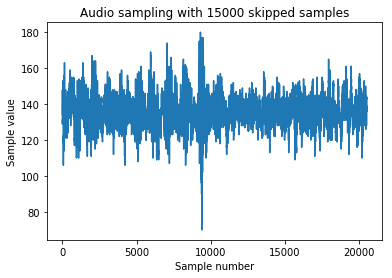

In [71]:
rate, audio = wavfile.read('file2.wav')
mono_audio = audio[:, 0]
print(f'Audio shape= {audio.shape}')
step = abs(max(mono_audio.min(), mono_audio.max(), key=abs))
mono_audio = np.array((mono_audio + step) / 2 / np.max(mono_audio) * 256, dtype=np.int16)
plt.plot(mono_audio[15000::10])
plt.xlabel('Sample number')
plt.ylabel('Sample value')
plt.title('Audio sampling with 15000 skipped samples')

In [49]:
ALPHA = 1.99999
x_0 = np.array([0.141592, 0.653589,0.793238, 0.462643, 0.383279,0.502884, 0.197169, 0.399375], dtype=np.float64)

def tent_map(x):
    if x < 0.5:
        return ALPHA*x
    return ALPHA*(1-x)

def swap_bits(x):
    first_part = str(x[: 32])
    second_part = str(x[32:])
    return second_part + first_part
    
def to_size_sample(data, size):
    parts = len(data)*256 // size
    huge_str = ''.join(data)
    return [huge_str[i*size:(i+1)*size] for i in range(parts)]

def calc_entropy(x):
    sample = to_size_sample(x, 8)
    cnt = Counter()
    for word in sample:
        cnt[word] += 1
    amount = sum(cnt.values())- cnt['']
    H = 0
    for val in cnt.values():
        if val == cnt['']:
            continue
        H -= val / amount * np.log2(val/amount)
    
        
    return H / 8

def TRNG(audio_sample, RN_size, CCML_size=8, x_0=x_0, entropy_mode=False):
    """
    audio_sample: audio sample, A in article
    RN_size: size of requiered random number (size divided on 256??), N in article
    CCML_size: size of CMML (???) L in article
    x_0: FP values
    """
    L = CCML_size
    
    gamma = L // 2
    n =  RN_size * L
    eps = 0.05
    transient_effect_bits = 15000
    audio_samples = audio_sample[transient_effect_bits:transient_effect_bits+n] # cut samples as in article to "eliminate the transient effect"
    
    # extraction of 3 LSB:
    mask = 0b00000111 # mask to extract 3 last bits
    audio_samples = [sample & mask for sample in audio_samples] # r^i in article
    
    
    x_next_t = x_0[:]
    x_cur_t = x_next_t[:]
    z = [0]*L

    output_number = [] # output number as array of bits, O in article
    c = 0
    
    while len(output_number) < RN_size:
        
        for i in range(L):
            x_cur_t[i] = ((0.071428571 * audio_samples[c*100%len(audio_samples)]) + x_cur_t[i]) * 0.666666667
            c += 1
            
        for t in range(gamma):
            for i in range(L):
                x_next_t[i] = (1-eps)*tent_map(x_cur_t[i]) + eps / 2 * (tent_map(x_cur_t[(i+1)%L]) + tent_map(x_cur_t[(i-1)%L]))
        for i in range(L):
            z[i] = bitstring.BitArray(float=x_cur_t[i], length=64).bin
            
        for  i in range(gamma - 1):
            z[i] = bin(int(z[i], 2) ^ int(swap_bits(z[i + gamma]),2))[2:]
        
        output_number.append(''.join(map(str, z[0] + z[1] + z[2] + z[3])))
        
        if entropy_mode:
            x_cur_t = x_0[:]
    return output_number


In [72]:
begin = time()
res = TRNG(audio_sample=mono_audio, RN_size=32768, entropy_mode=False)
print(time() - begin)

8.034599542617798


In [73]:
with open('to_test.bin', 'w') as f:
    for i in range(len(res)):
        if len(res[i]) == 0:
            break
        f.write(f'{res[i]}\n')
##To diehard tests
#!./script.sh

In [83]:
res[:3]

['110011100100110011110001101001010101110101110010001001100100110100001010111000100100100110111011111011100001111001000101000101111111000000001000010101010011110110011001110011101011011110110011111111101110101010101001010111000110001101000001111000011011',
 '101100101101110110011110101111011011101100010000100111110011010111110111111011000110001010011011001010100100010110111000001101101011001101010000010100110100111111100101010011001110101100100011111111001110001100110111101100001001010100000001100101110001',
 '111000011101000011011011011011101010111010011010110110100011111111000111010111111111110000000110111001000110101011001110000010111010100001111010010010010011111010011111101100001110000101001010011111111010101011000011100000010101101111010010110011000101001']

In [82]:
count0 = 0
count1 = 0
for i in range(len(res)):
    count0 += res[i].count('0')
    count1 += res[i].count('1')
print(f'rate of 0: {count0 / (count0 + count1)},\nrate of 1: {count1 / (count0 + count1)}')
print(f"P-value: {(count1 - count0) / np.sqrt(count0+count1)}")

rate of 0: 0.4828348962757061,
rate of 1: 0.5171651037242939
P-value: 98.84365466736371


In [84]:
size= 8
byte_blocks=to_size_sample(res, size)
entropy=calc_entropy(byte_blocks)
print(f'Entropy: {entropy}')


Entropy: 0.9977827585129562


In [85]:
begin = time()
res_nibble = TRNG(audio_sample=mono_audio, RN_size=1000000//256)
print(f'Speed performance: {1/(time() - begin)} Mbit/s')

Speed performance: 1.0889843996246729 Mbit/s


In [86]:
def histogram(nibble):
    sample = to_size_sample(nibble, 4)
    cnt = Counter()
    for word in sample:
        cnt[word] += 1
    vals = [(int(key, 2), int(val)) for key,val in cnt.items() if len(key) == 4]
    return vals

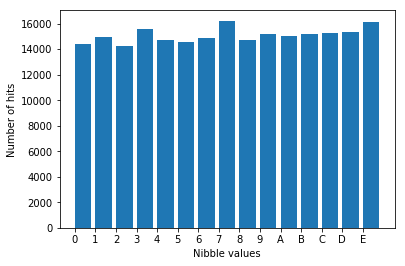

In [87]:
ax = plt.gca()
g = np.array(histogram(res_nibble))
g = np.array(sorted(g, key=lambda x: x[0]))
ax.bar(g[:, 0][:-1], g[:, 1][:-1], align='edge')
plt.ylabel('Number of hits')
plt.xlabel('Nibble values')
xval = [hex(i)[2:].upper() for i in range(15)]
plt.xticks(g[:,0][:-1], xval)
plt.show()

In [90]:
# simulated signals (0,0, ...), (1,0, ...) 
def sense_prod(x1, x2):
    xor = [int(x1[i], 2)^int(x2[i], 2) for i in range(len(x1)) if x1[i] and x2[i]]
    bit_xor = list(map(lambda x: bin(x)[2:], xor))
    return bit_xor

begin = time()
RN_size= 4000000//256
sens_aud = [0]*RN_size
sens_aud2 = sens_aud[:]
sens_aud2[0] = 1
res_sens = TRNG(audio_sample=sens_aud, RN_size=RN_size, entropy_mode=True)
res_sens2 = TRNG(audio_sample=sens_aud2, RN_size=RN_size, entropy_mode=True)
print(time() - begin)

6.220045328140259


In [91]:
xor_blocks =sense_prod(res_sens, res_sens2)
sens_entropy = calc_entropy(xor_blocks)
print(f'Sensitive entropy: {sens_entropy}')

Sensitive entropy: 0.9946851769929416
